In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

nltk.download("punkt", quiet=True)

from sklearn.cluster import KMeans  # Import KMeans
from collections import Counter  # Import Counter for counting categories


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Configuration
SEQUENCE_LENGTH = 7
BATCH_SIZE = 256
EPOCHS = 100
HIDDEN_SIZE = 64

In [ ]:
class LogAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.scaler = MinMaxScaler()
        self.model = None
        self.sequences = None
        self.test_data = None

    def calculate_threshold(self, errors):
        """
        Calculate the dynamic threshold based on rolling mean and standard deviation.
        """
        rolling_mean = pd.Series(errors).rolling(window=1000, min_periods=1).mean()
        rolling_std = pd.Series(errors).rolling(window=1000, min_periods=1).std()
        return (rolling_mean + 3 * rolling_std).max()

    def _load_data(self):
        dtype_spec = {
            "IP Address": "category",
            "Timestamp": "string",
            "Request": "string",
            "Status": "int16",
        }
        df = pd.read_csv(
            self.file_path,
            usecols=["IP Address", "Timestamp", "Request", "Status"],
            parse_dates=["Timestamp"],
            dtype=dtype_spec,
        )
        df.columns = df.columns.str.strip()
        print("Columns in CSV file:", df.columns.tolist())
        return df

    def _extract_features(self, df):
        df["hour"] = df.Timestamp.dt.hour
        df["day"] = df.Timestamp.dt.date
        daily_groups = df.groupby("day")

        time_features = daily_groups.apply(self._time_features)
        url_features = daily_groups.Request.apply(self._url_analysis)

        ip_status = daily_groups.agg(
            {
                "IP Address": lambda x: x.mode()[0],
                "Status": lambda x: x.mode()[0],
                "Request": "count",
            }
        ).rename(columns={"Request": "request_count"})

        ip_status["ip_numeric"] = ip_status["IP Address"].cat.codes
        features = pd.concat([time_features, url_features, ip_status], axis=1)

        for col in features.select_dtypes(include=["category"]).columns:
            features[col] = features[col].cat.codes

        return features.fillna(0)

    def _time_features(self, group):
        times = group.Timestamp.sort_values()
        diffs = times.diff().dt.total_seconds().dropna()
        return pd.Series(
            {
                "time_max": diffs.max() if not diffs.empty else 0,
                "time_mean": diffs.mean() if not diffs.empty else 0,
                "time_sum": diffs.sum() if not diffs.empty else 0,
                "time_var": diffs.var() if not diffs.empty else 0,
            }
        )

    def _url_analysis(self, urls):
        text = " ".join(urls).lower()
        text = re.sub(r"\d+|[%s]" % re.escape(string.punctuation), "", text)
        tokens = [
            t for t in word_tokenize(text) if t not in {"get", "post", "http", "https"}
        ]

        counts = Counter(tokens)
        bigrams = Counter(ngrams(tokens, 2))
        trigrams = Counter(ngrams(tokens, 3))

        return pd.Series(
            {
                "top_page": counts.most_common(1)[0][1] if tokens else 0,
                "top_bigram": bigrams.most_common(1)[0][1] if bigrams else 0,
                "top_trigram": trigrams.most_common(1)[0][1] if trigrams else 0,
            }
        )

    def _create_sequences(self, data):
        scaled = self.scaler.fit_transform(data)
        sequences = []
        for i in range(len(scaled) - SEQUENCE_LENGTH):
            sequences.append(scaled[i : i + SEQUENCE_LENGTH])
        return torch.tensor(sequences, dtype=torch.float32)

    def build_model(self, input_size):
        class Autoencoder(nn.Module):
            def __init__(self):
                super().__init__()
                self.encoder_lstm = nn.LSTM(
                    input_size,
                    HIDDEN_SIZE,
                    batch_first=True,
                    num_layers=2,
                    bidirectional=True,
                )
                self.encoder_dropout = nn.Dropout(0.2)
                self.decoder_lstm = nn.LSTM(
                    HIDDEN_SIZE * 2, input_size, batch_first=True, num_layers=2
                )
                self.decoder_dropout = nn.Dropout(0.2)

            def forward(self, x):
                encoded, _ = self.encoder_lstm(x)
                encoded = self.encoder_dropout(encoded)
                encoded = (
                    encoded[:, -1, :].unsqueeze(1).repeat(1, SEQUENCE_LENGTH, 1)
                )  # Repeat across sequence length
                decoded, _ = self.decoder_lstm(encoded)
                return decoded

        return Autoencoder()

    def train(self):
        print("Loading and processing data...")
        raw_data = self._load_data()
        features = self._extract_features(raw_data)
        self.sequences = self._create_sequences(features)

        train_data, self.test_data = train_test_split(
            self.sequences, test_size=0.2, shuffle=False
        )
        train_loader = DataLoader(
            TensorDataset(train_data, train_data), batch_size=BATCH_SIZE, shuffle=True
        )

        self.model = self.build_model(features.shape[1])
        self.model = self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        import logging
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(__name__)
        logger.info("Starting training...")
        losses = []
        # Early stopping parameters
        early_stopping_patience = 10
        best_loss = float('inf')
        patience_counter = 0

        for epoch in range(EPOCHS):
            self.model.train()
            epoch_loss = 0
            for batch in train_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            losses.append(avg_loss)
            # Early stopping logic
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f}")

        plt.plot(losses)
        plt.title("Training Loss Progress")
        plt.xlabel("Epochs")
        plt.ylabel("Reconstruction Error")
        plt.savefig("training_loss.png")
        plt.close()

    def detect_anomalies(self):
        with torch.no_grad():
            self.model.eval()
            errors = []
            for i in range(0, len(self.sequences), BATCH_SIZE):
                batch = self.sequences[i : i + BATCH_SIZE].to(device)
                reconstructions = self.model(batch)
                batch_errors = torch.mean((batch - reconstructions) ** 2, dim=(1, 2))
                errors.extend(batch_errors.cpu().numpy())

        errors_np_array = np.array(errors)
        threshold = np.percentile(errors_np_array, 95)
        anomalies = errors_np_array > threshold

        plt.figure(figsize=(12, 6))
        plt.plot(errors_np_array, alpha=0.7)
        plt.axhline(threshold, c="r", linestyle="--")
        plt.scatter(np.where(anomalies)[0], errors_np_array[anomalies], c="r", s=20)
        plt.title("Anomaly Detection Results")
        plt.xlabel("Sequence Index")
        plt.ylabel("Reconstruction Error")
        plt.savefig("anomalies.png")

        # Generate detailed report for anomalies
        with open("anomaly_report.txt", "w") as report_file:
            report_file.write("Detailed Anomaly Detection Report\n")
            report_file.write("===============================\n\n")
            report_file.write(f"Total Anomalies Detected: {sum(anomalies)}\n")
            report_file.write(f"Threshold: {threshold:.4f}\n\n")
            report_file.write("Anomalies:\n")
            for idx in np.where(anomalies)[0]:
                report_file.write(
                    f"Index: {idx}, Reconstruction Error: {errors_np_array[idx]:.4f}\n"
                )

        return anomalies, errors_np_array, threshold

    def evaluate_model(self):
        with torch.no_grad():
            self.model.eval()
            test_loader = DataLoader(
                TensorDataset(self.test_data, self.test_data),
                batch_size=BATCH_SIZE,
                shuffle=False,
            )
            total_loss = 0
            all_targets = []
            all_outputs = []
            for batch in test_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = nn.MSELoss()(outputs, targets)
                total_loss += loss.item()
                all_targets.extend(targets.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())

            avg_loss = total_loss / len(test_loader)
            mse = mean_squared_error(
                np.array(all_targets).reshape(len(all_targets), -1),
                np.array(all_outputs).reshape(len(all_outputs), -1),
            )

            print(f"Test MSE: {mse:.4f}")

            # Calculate accuracy for anomaly detection
            errors = np.mean((np.array(all_targets) - np.array(all_outputs)) ** 2, axis=1)

            # Flatten errors to ensure it is 1D
            errors = errors.flatten()

            # Use the calculate_threshold method
            Dthreshold = self.calculate_threshold(errors)
            print(f"Dynamic threshold is: {Dthreshold}")
            threshold = Dthreshold  # Use the dynamic threshold directly
            predictions = errors > Dthreshold
            true_labels = predictions
            accuracy = accuracy_score(true_labels, predictions)
            print(f"Anomaly Detection Accuracy: {accuracy:.4f}")

            return avg_loss, mse, accuracy

Loading and processing data...


C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_21560\2390897429.py:24: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Columns in CSV file: ['IP Address', 'Timestamp', 'Request', 'Status']


C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_21560\2390897429.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_features = daily_groups.apply(self._time_features)
C:\Users\ARYAN PRAKASH\AppData\Local\Temp\ipykernel_21560\2390897429.py:94: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(sequences, dtype=torch.float32)
INFO:__main__:Starting training...


Epoch 1/300 | Loss: 0.0733
Epoch 11/300 | Loss: 0.0330
Epoch 21/300 | Loss: 0.0180
Epoch 31/300 | Loss: 0.0136
Epoch 41/300 | Loss: 0.0122
Epoch 51/300 | Loss: 0.0116
Epoch 61/300 | Loss: 0.0111
Epoch 71/300 | Loss: 0.0104
Epoch 81/300 | Loss: 0.0083
Epoch 91/300 | Loss: 0.0074
Epoch 101/300 | Loss: 0.0069
Epoch 111/300 | Loss: 0.0065
Epoch 121/300 | Loss: 0.0063
Epoch 131/300 | Loss: 0.0060
Epoch 141/300 | Loss: 0.0059
Epoch 151/300 | Loss: 0.0057
Epoch 161/300 | Loss: 0.0056
Epoch 171/300 | Loss: 0.0055
Epoch 181/300 | Loss: 0.0053
Epoch 191/300 | Loss: 0.0053
Epoch 201/300 | Loss: 0.0052
Epoch 211/300 | Loss: 0.0051
Epoch 221/300 | Loss: 0.0051
Epoch 231/300 | Loss: 0.0049
Epoch 241/300 | Loss: 0.0049
Epoch 251/300 | Loss: 0.0048
Epoch 261/300 | Loss: 0.0048
Epoch 271/300 | Loss: 0.0047
Epoch 281/300 | Loss: 0.0046
Epoch 291/300 | Loss: 0.0047
Test MSE: 0.0020
Dynamic threshold is: 0.07685233724334609
Anomaly Detection Accuracy: 1.0000

Detected 62 anomalies
Threshold: 0.0215
Top 5 

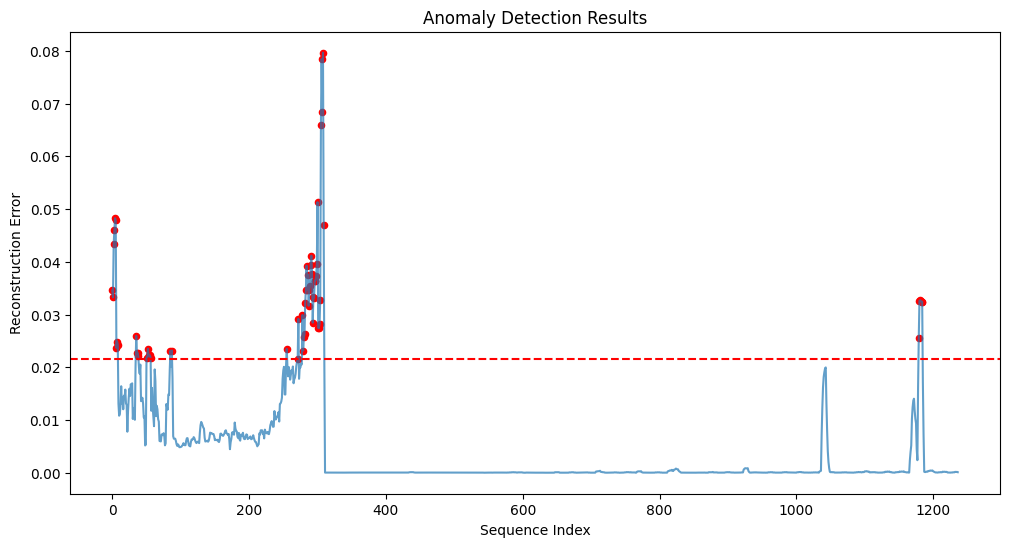

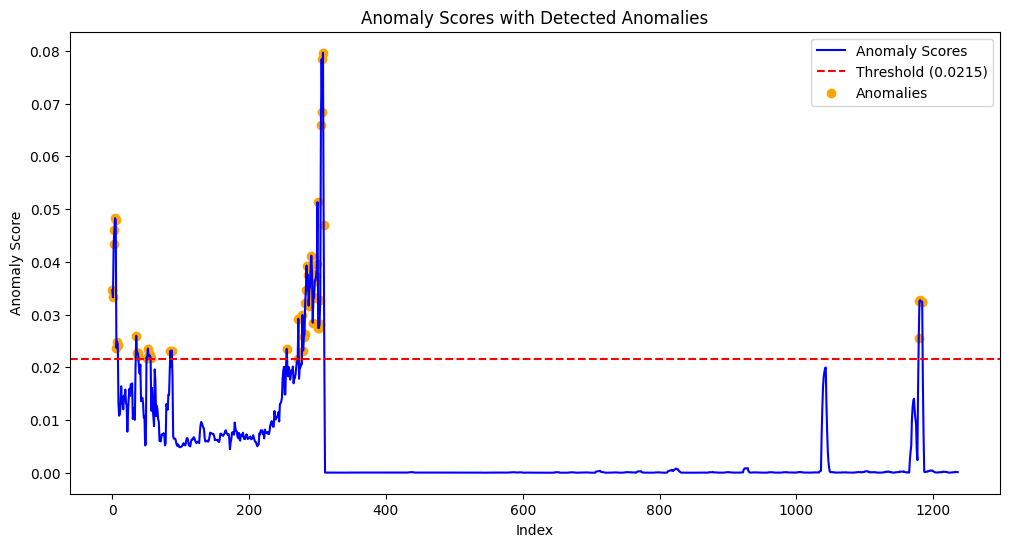

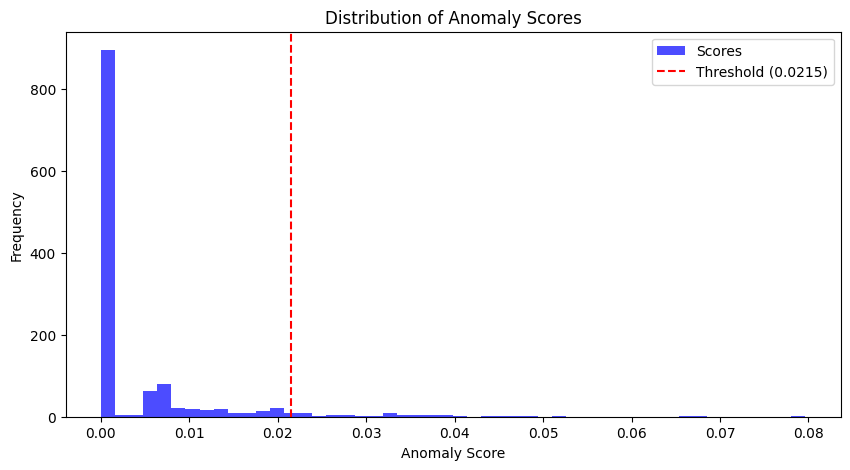

Anomaly at index 0 categorized as: SQL Injection
Anomaly at index 1 categorized as: Brute Force
Anomaly at index 2 categorized as: Brute Force
Anomaly at index 3 categorized as: Brute Force
Anomaly at index 4 categorized as: Brute Force
Anomaly at index 5 categorized as: SQL Injection
Anomaly at index 6 categorized as: SQL Injection
Anomaly at index 7 categorized as: SQL Injection
Anomaly at index 8 categorized as: SQL Injection
Anomaly at index 9 categorized as: SQL Injection
Anomaly at index 10 categorized as: SQL Injection
Anomaly at index 11 categorized as: DDoS
Anomaly at index 12 categorized as: Brute Force
Anomaly at index 13 categorized as: Brute Force
Anomaly at index 14 categorized as: SQL Injection
Anomaly at index 15 categorized as: DDoS
Anomaly at index 16 categorized as: Brute Force
Anomaly at index 17 categorized as: Brute Force
Anomaly at index 18 categorized as: DDoS
Anomaly at index 19 categorized as: SQL Injection
Anomaly at index 20 categorized as: Brute Force
Anoma

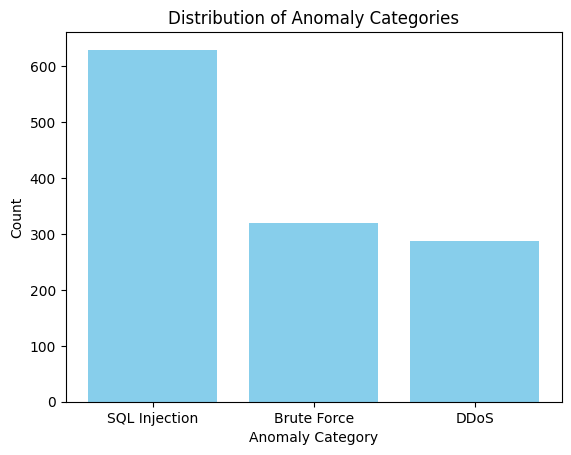

In [ ]:
if __name__ == "__main__":
    analyzer = LogAnalyzer("../dataset/access_log.txt/output.csv")
    analyzer.train()
    anomalies, scores, threshold = analyzer.detect_anomalies()
    avg_loss, mse, accuracy = analyzer.evaluate_model()

    print(f"\nDetected {sum(anomalies)} anomalies")
    print(f"Threshold: {threshold:.4f}")
    print("Top 5 Anomalies:")
    for idx in np.argsort(scores)[-5:]:
        print(f"Index {idx} - Score: {scores[idx]:.4f}")
    print(f"\nModel Evaluation:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Anomaly Detection Accuracy: {accuracy:.4f}")

    # Visualization of Anomaly Scores
    plt.figure(figsize=(12, 6))
    plt.plot(scores, label="Anomaly Scores", color="blue")
    plt.axhline(
        y=threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.4f})"
    )
    plt.scatter(
        np.where(anomalies)[0],
        np.array(scores)[anomalies],
        color="orange",
        label="Anomalies",
    )
    plt.title("Anomaly Scores with Detected Anomalies")
    plt.xlabel("Index")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.show()

    # Histogram of Anomaly Scores
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=50, color="blue", alpha=0.7, label="Scores")
    plt.axvline(
        x=threshold, color="red", linestyle="--", label=f"Threshold ({threshold:.4f})"
    )
    plt.title("Distribution of Anomaly Scores")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Feature extraction for anomalies (example features)
    features = np.array(
        [
            # Replace with actual feature extraction logic
            [request_frequency, unusual_status_code, suspicious_url_pattern]
            for request_frequency, unusual_status_code, suspicious_url_pattern in zip(
                np.random.rand(
                    len(scores)
                ),  # Example: Random feature for request frequency
                np.random.randint(
                    0, 2, len(scores)
                ),  # Example: Binary feature for status codes
                np.random.randint(
                    0, 2, len(scores)
                ),  # Example: Binary feature for suspicious URLs
            )
        ]
    )

    # Normalize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply K-Means clustering for categorization
    kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
    categories = kmeans.fit_predict(features_scaled)

    # Map categories to anomaly types
    category_labels = {0: "DDoS", 1: "SQL Injection", 2: "Brute Force"}
    categorized_anomalies = [category_labels[cat] for cat in categories]

    # Print categorized anomalies
    for idx, category in enumerate(categorized_anomalies):
        print(f"Anomaly at index {idx} categorized as: {category}")

    # Visualization of categorized anomalies
    category_counts = Counter(categorized_anomalies)
    plt.bar(category_counts.keys(), category_counts.values(), color="skyblue")
    plt.title("Distribution of Anomaly Categories")
    plt.xlabel("Anomaly Category")
    plt.ylabel("Count")
    plt.show()

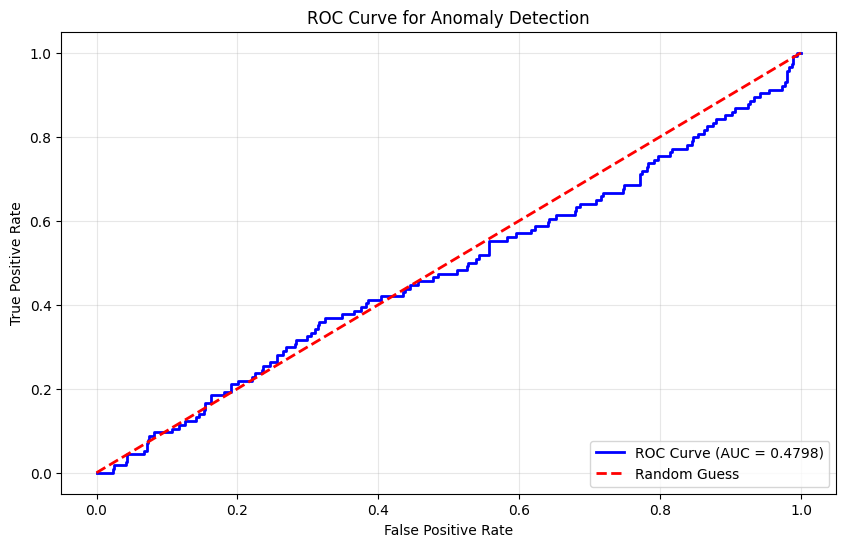

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following:
# scores: Array of reconstruction errors (equivalent to errors_np_array)
# anomalies: Boolean array indicating detected anomalies (1 for anomaly, 0 for normal)

# Example ground truth (replace with actual labels if available)
true_labels = np.random.choice([0, 1], size=len(scores), p=[0.9, 0.1])  # Simulated ground truth

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Guess')
plt.title('ROC Curve for Anomaly Detection')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Sequences shape: torch.Size([1237, 7, 9])
Reconstructions shape: torch.Size([1237, 7, 9])
Errors shape: (1237,)


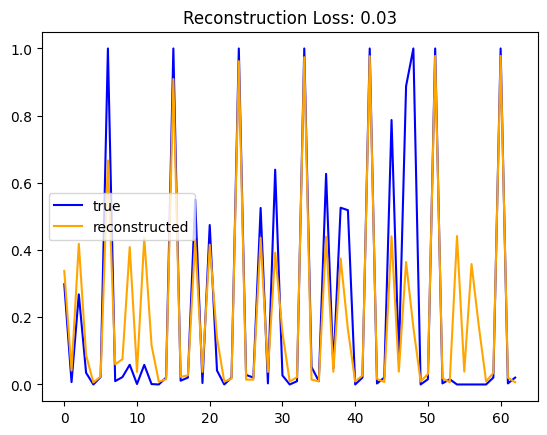

Anomalies detected: 62
Threshold: 0.0215102069079876


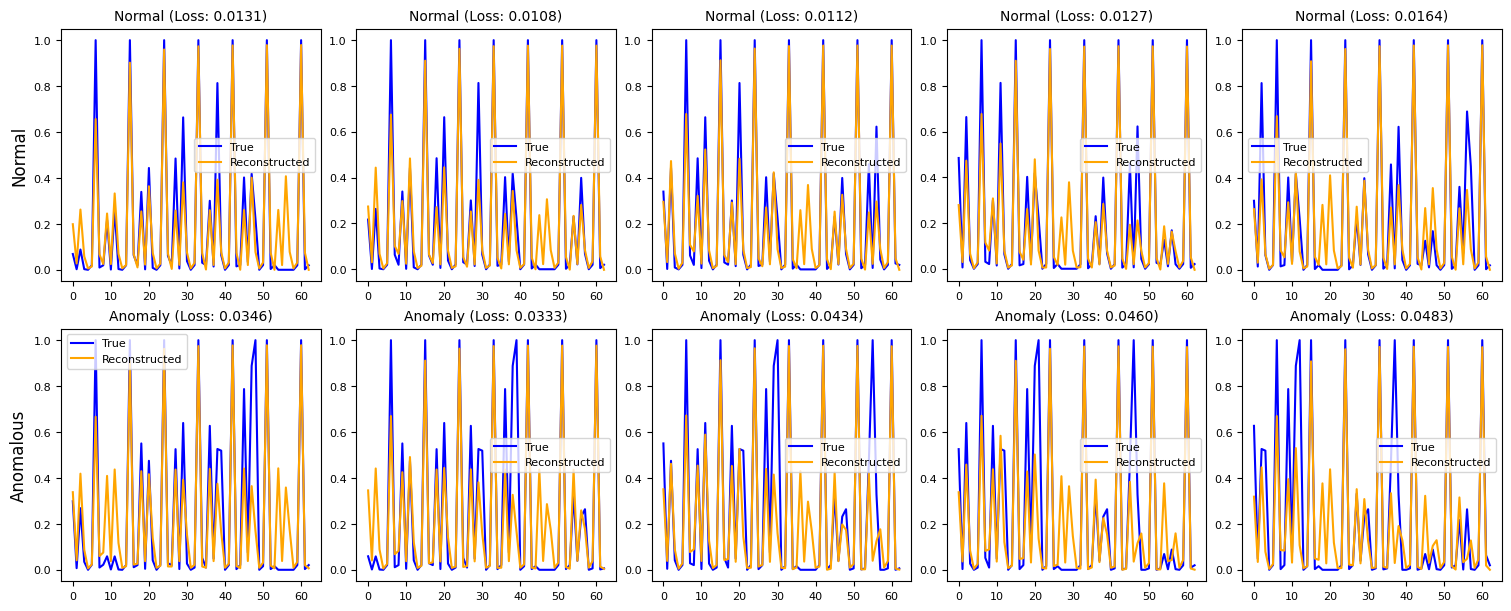

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_anomaly_reconstruction(errors_np_array, sequences, reconstructions, anomalies, threshold, num_samples=5):
    """
    Plots reconstruction errors for normal and anomalous sequences.

    Parameters:
    - errors_np_array: Array of reconstruction errors.
    - sequences: Original input sequences.
    - reconstructions: Reconstructed sequences from the model.
    - anomalies: Boolean array indicating detected anomalies.
    - threshold: Threshold used for anomaly detection.
    - num_samples: Number of samples to plot for each category (normal and anomaly).
    """
    # Ensure reconstructions and sequences are aligned
    assert len(sequences) == len(reconstructions), "Sequences and reconstructions must have the same length."
    assert len(errors_np_array) == len(sequences), "Errors must correspond to the sequences."

    # Separate normal and anomalous indices
    normal_indices = np.where(~anomalies)[0]
    anomaly_indices = np.where(anomalies)[0]

    # Select samples to plot
    normal_samples = normal_indices[:num_samples]
    anomaly_samples = anomaly_indices[:num_samples]

    # Adjust figure size and layout
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6), constrained_layout=True)

    # Plot normal samples
    for i, idx in enumerate(normal_samples):
        axes[0, i].plot(sequences[idx].cpu().numpy().flatten(), label="True", color="blue")
        axes[0, i].plot(reconstructions[idx].cpu().detach().numpy().flatten(), label="Reconstructed", color="orange")
        axes[0, i].set_title(f"Normal (Loss: {errors_np_array[idx]:.4f})", fontsize=10)
        axes[0, i].tick_params(axis='both', which='major', labelsize=8)
        axes[0, i].legend(fontsize=8)

    # Plot anomalous samples
    for i, idx in enumerate(anomaly_samples):
        axes[1, i].plot(sequences[idx].cpu().numpy().flatten(), label="True", color="blue")
        axes[1, i].plot(reconstructions[idx].cpu().detach().numpy().flatten(), label="Reconstructed", color="orange")
        axes[1, i].set_title(f"Anomaly (Loss: {errors_np_array[idx]:.4f})", fontsize=10)
        axes[1, i].tick_params(axis='both', which='major', labelsize=8)
        axes[1, i].legend(fontsize=8)

    # Add labels for rows
    axes[0, 0].set_ylabel("Normal", fontsize=12)
    axes[1, 0].set_ylabel("Anomalous", fontsize=12)

    plt.show()

# Example usage:
# Ensure that sequences and reconstructions are defined
sequences = analyzer.sequences  # Use the sequences from the LogAnalyzer instance
reconstructions = analyzer.model(sequences.to(device))  # Generate reconstructions using the model

# Ensure errors_np_array is calculated correctly
errors_np_array = np.mean((sequences.cpu().detach().numpy() - reconstructions.cpu().detach().numpy()) ** 2, axis=(1, 2))

# Ensure anomalies are calculated correctly
anomalies = errors_np_array > threshold

print("Sequences shape:", sequences.shape)
print("Reconstructions shape:", reconstructions.shape)
print("Errors shape:", errors_np_array.shape)
idx = 0  # Example index
plt.plot(sequences[idx].cpu().detach().numpy().flatten(), label="true", color="blue")
plt.plot(reconstructions[idx].cpu().detach().numpy().flatten(), label="reconstructed", color="orange")
plt.title(f"Reconstruction Loss: {errors_np_array[idx]:.2f}")
plt.legend()
plt.show()
print("Anomalies detected:", np.sum(anomalies))
print("Threshold:", threshold)

# Call the function to plot the graphs
plot_anomaly_reconstruction(errors_np_array, sequences, reconstructions, anomalies, threshold)